In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# When you re-run the notebook without restarting the kernel

tf.reset_default_graph()

In [4]:
# To produce the same output

np.random.seed(42)
tf.set_random_seed(42)

### Some samples:

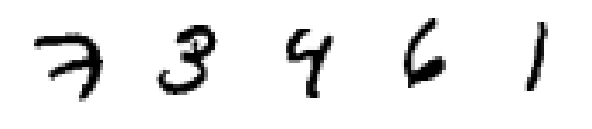

In [5]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [6]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

In [7]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

In [8]:
# Primary Capsules
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

In [9]:
conv1_params = {
    # Conv1 has 256, 9x9 convolution kernels with a stride of 1 and ReLU activation
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    #  The second layer (PrimaryCapsules) is a convolutional capsule layer with 32
    #  channels of covolutional 8D capsules.
    #
    #  Each primary capsules contains 8 convolutional units with 9x9 kernels
    #  and a stride of 2.
    
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [10]:
conv1 = tf.layers.conv2d(inputs = X    , name = "conv1", **conv1_params)
conv2 = tf.layers.conv2d(inputs = conv1, name = "conv2", **conv2_params)

print("conv1 shape : ", conv1.shape) # 20x20x256
print("conv2 shape : ", conv2.shape) # 6x6x(8x32)

# PrimaryCapsules has [32x6x6] capsule outputs(each output is an 8D vector) and
# each capsule in the [6x6] grid is sharing their weights with each other.

conv1 shape :  (?, 20, 20, 256)
conv2 shape :  (?, 6, 6, 256)


In [11]:
conv1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims], name = "caps1_raw")

print("conv1_raw shape : ", conv1_raw.shape) # (6x6x32)x8, 8 = caps1_n_dims

conv1_raw shape :  (?, 1152, 8)


In [12]:
def squash(s, axis = -1, epsilon = 1e-7, name = None):
    with tf.name_scope(name, default_name = "squash"):
        squared_norm  = tf.reduce_sum(tf.square(s), axis = axis, keep_dims = True)
        safe_norm     = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1.0 + squared_norm)
        
        return squash_factor * s / safe_norm

In [13]:
caps1_output = squash(conv1_raw, name = "caps1_output")

print("caps1_output shape : ", caps1_output.shape)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
caps1_output shape :  (?, 1152, 8)


## Digit Capsules

In [14]:
caps2_n_caps = 10
caps2_n_dims = 16

In [15]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")

print("caps1_output_expanded shape : ", caps1_output_expanded.shape)

caps1_output_tile     = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")

print("caps1_output_tile shape : ", caps1_output_tile.shape)

caps1_output_expanded shape :  (?, 1152, 8, 1)
caps1_output_tile shape :  (?, 1152, 1, 8, 1)


In [16]:
init_sigma = 0.1

W_init = tf.random_normal(
                    shape=(1, caps1_output_tile.shape[ 1].value, caps2_n_caps * caps2_n_dims, 
                              caps1_output_tile.shape[-2].value, caps1_output_tile.shape[-1].value),
                    stddev=init_sigma, dtype=tf.float32, name="W_init")

W      = tf.Variable(W_init, name="W")

biases = tf.get_variable('bias', shape = (1 , 1, caps2_n_caps, caps2_n_dims, 1))

print("W shape: ", W.shape)
print("biases shape: ", biases.shape)

W shape:  (1, 1152, 160, 8, 1)
biases shape:  (1, 1, 10, 16, 1)


In [17]:
caps1_output_tiled    = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps * caps2_n_dims, 1, 1],
                             name="caps1_output_tiled")

print("caps1_output_tiled : ", caps1_output_tiled.shape)

caps1_output_tiled :  (?, 1152, 160, 8, 1)


In [18]:
u_hat = tf.reduce_sum(W * caps1_output_tiled, axis = 3, keep_dims = True)

print("u_hat shape: ", u_hat.shape)

u_hat shape:  (?, 1152, 160, 1, 1)


In [19]:
u_hat = tf.reshape(u_hat, shape = [-1, u_hat.shape[1].value, caps2_n_caps, caps2_n_dims, 1])

print("u_hat shape: ", u_hat.shape)

u_hat shape:  (?, 1152, 10, 16, 1)


In [20]:
u_hat_stopped = tf.stop_gradient(u_hat, name = 'stop_gradient')

In [21]:
batch_size = tf.shape(X)[0]
b_IJ = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1], dtype = tf.float32, name = 'b_IJ')

print("b_IJ.shape = ", b_IJ.shape)

b_IJ.shape =  (?, 1152, 10, 1, 1)


## Routing by agreement

In [22]:
rounds = 2

for r_iter in range(rounds):
    with tf.variable_scope('iter_' + str(r_iter)):
        c_IJ = tf.nn.softmax(b_IJ, axis=2)
        
        if r_iter == rounds - 1:
            s_J = tf.multiply(c_IJ, u_hat)
            s_J = tf.reduce_sum(s_J, axis = 1, keepdims = True) + biases
            v_J = squash(s_J) 
            
        elif r_iter < rounds - 1:
            s_J = tf.multiply(b_IJ, u_hat_stopped)
            s_J = tf.reduce_sum(s_J, axis = 1, keepdims = True) + biases
            
            v_J = squash(s_J)
            
            v_J_tiled   = tf.tile(v_J, [1, u_hat.shape[1].value, 1, 1, 1])
            print("v_J_tiled.shape = ", v_J_tiled.shape)
            u_produce_v = tf.reduce_sum(u_hat_stopped * v_J_tiled, axis = 3, keepdims = True)
            
            print("u_produce_v.shape = ", u_produce_v.shape)
            b_IJ += u_produce_v

            
caps2_output = v_J

v_J_tiled.shape =  (?, 1152, 10, 16, 1)
u_produce_v.shape =  (?, 1152, 10, 1, 1)


## Dynamic Loop

In [23]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.Session() as sess:
    print(sess.run(result))

(328350, 100)


In [24]:
sum([i**2 for i in range(1, 100 + 1)])

338350

## Estimated Class Probabilities

In [25]:
print("caps2_output shape : ", caps2_output.shape)

caps2_output shape :  (?, 1, 10, 16, 1)


In [26]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [27]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

print("y_proba shape : ", y_proba.shape)

y_proba shape :  (?, 1, 10, 1)


In [28]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

In [29]:
print("y_proba_argmax shape : ", y_proba_argmax.shape)

y_proba_argmax shape :  (?, 1, 1)


In [30]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [31]:
# Labels

y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

## Margin Loss

In [32]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [33]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

print("T shape : ", T.shape)

T shape :  (?, 10)


In [34]:
with tf.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [35]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

print("caps2_output_norm shape : ", caps2_output_norm.shape)

caps2_output_norm shape :  (?, 1, 10, 1, 1)


In [36]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")

print("present_error_raw shape : ", present_error_raw.shape)

present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

print("present_error shape : ", present_error.shape)

present_error_raw shape :  (?, 1, 10, 1, 1)
present_error shape :  (?, 10)


In [37]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")

print("absent_error_raw shape : ", absent_error_raw.shape)

absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

print("absent_error shape : ", absent_error.shape)

absent_error_raw shape :  (?, 1, 10, 1, 1)
absent_error shape :  (?, 10)


In [38]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

print("L shape : ", L.shape)

L shape :  (?, 10)


In [39]:
# Margin Loss

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

print("margin_loss shape : ", margin_loss.shape)

margin_loss shape :  ()


## Reconstruction

In [40]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

In [41]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

In [42]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

In [43]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>

In [44]:
caps2_output

<tf.Tensor 'iter_1/squash/truediv_1:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [45]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

In [46]:
reconstruction_mask_reshaped

<tf.Tensor 'reconstruction_mask_reshaped:0' shape=(?, 1, 10, 1, 1) dtype=float32>

In [47]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [48]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [49]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

In [50]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

## Decoder

In [51]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [52]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

## Reconstruction Loss

In [53]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

## Total Loss

In [54]:
alpha = 0.0005
#alpha = 0.0
loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

# Accuracy

In [55]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [56]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

In [57]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [58]:
n_epochs = 10
batch_size = 50
restore_checkpoint = False

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 98.9600%  Loss: 0.013421 (improved)
Epoch: 2  Val accuracy: 99.2200%  Loss: 0.008745 (improved)
Epoch: 3  Val accuracy: 99.4600%  Loss: 0.008114 (improved)
Epoch: 4  Val accuracy: 99.4000%  Loss: 0.007337 (improved)
Epoch: 5  Val accuracy: 99.2600%  Loss: 0.007228 (improved)
Epoch: 6  Val accuracy: 99.4200%  Loss: 0.006432 (improved)
Epoch: 7  Val accuracy: 99.4400%  Loss: 0.007008
Epoch: 8  Val accuracy: 99.5600%  Loss: 0.006214 (improved)
Epoch: 9  Val accuracy: 99.4600%  Loss: 0.007288
Epoch: 10  Val accuracy: 99.4600%  Loss: 0.007174


In [59]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final test accuracy: 99.4500%  Loss: 0.006010   


## Predictions

In [62]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


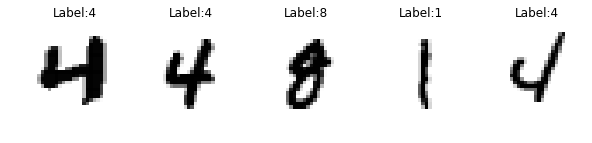

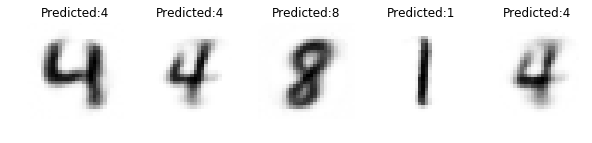

In [63]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()